## Projeto Final Aprendizado de Máquina

#### Duplas: Aliança BA-AL e Nemphis & Nempharey

#### Integrantes: Davi J.A. Pereira, Diogo P. de L. Carvalho, Mayllon E.P.S. Silva, Samuel S. de Araújo

### Notebook 3: RIDGE

# INTRODUÇÃO

Nesse notebook, será visto o funcionamento do modelo de regressão do tipo Ridge, um dos modelos mais famos para regressões lineares. 
OBS: É interessante que já tenha visto o notebook "Notebook_1_Preparação_Dados.ipynb"

Os tópicos abordados serão:

- Como funciona?

- Ridge Regressor no scikitlearn

- Aplicando o modelo na previsão de Temperatura Crítica de materiais

    ~Modelo e espaço de busca

    ~Função Objetivo
    
    ~Otimização sem LBFGS
    
    ~Otimização para o solucionador LBFGS
    
    ~Observando resultados
    
- PCA para visualização gráfica

- Conclusão
    

# Importações 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as r2
from sklearn.decomposition import PCA
from optuna import create_study, Trial

# COMO FUNCIONA?

Em tradução livre regressão de cume ou de crista, é um modelo que considera a variância(medida de quão próximo é o modelo dos dados, por exemplo o RMSE é uma das formas de medir os resíduos) e o BIAS(medida que considera o alinhamento do gráfico com as amostras, ou seja, a incapacidade de chegar a relação correta dos dados). 


As imagens abaixo são da referência [2].

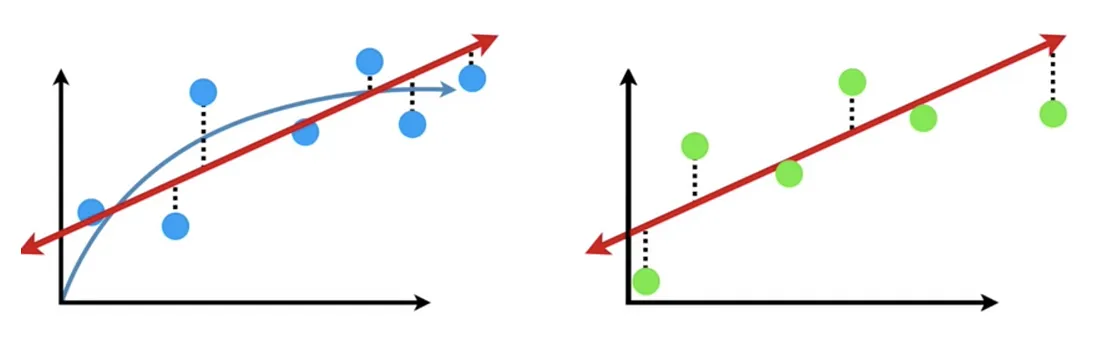



Na imagem acima, temos, a direita, um exemplo de regressão linear padrão considerando os resíduos(distância dos pontos em relação ao modelo), e, a esquerda, temos a representação de um modelo que considera o resíduo e o BIAS.

A parte do BIAS no modelo é conhecida como penalidade da regressão Ridge, e ela é calculada multiplicando λ pelo quadrado do peso de cada feature, sendo que λ pode assumir qualquer valor positivo.


A função de perda do modelo de regressão ridge é dada por: **Min(||Y – X(theta)||^2 + λ||theta||^2)**

Onde **|Y – X(theta)||^2** representa a doma dos quadrados dos resíduos, utilizada para o ajuste do modelo de regressão linear padrão.

E **λ||theta||^2** é a penalidade da parte do BIAS, no qual podemos ver o  λ multiplicando o quadrado de uma única feature

Um ponto que vale ressaltar é que λ é denotado, na função de regressão linear de diversas bibliotecas, como alpha. Logo o parâmetro alpha dos modelos indica o  λ da função de perda.

Em um modelo de regressão linear simples, temos **Y = X*B + e**, onde y é a variável dependente, x as independentess, B são os coeficientes de regressão e **e** representa os resíduos.  Essa função representa a primeira parte de função de perda da Ridge, sendo que anulamos o BIAS quando colocamos um alpha igual zero, ou seja, transformamos o modelo Ridge em uma regressão linear simples.

Ao mudar o valor de  λ, ajustamos a função de perda, quanto maior for  λ, maior vai ser a penalidade e menor a grandeza dos coeficientes, sendo que as operações utilizam os coeficientes normalizados e, ao final, são convertidos para a escala original

Um dos pontos mais importantes de regressão de Ridge é a compensação de variância e viés, onde temos uma relação direta com λ. Quanto maior for λ, maior o viés e menor a variância.

# Ridge regressor no skilearn

Na biblioteca scikitlearn, o modelo de regressão ridge tem os seguintes parâmetros:

`alpha`: O alpha representa o valor de lambda da função de custo como foi discutido acima.

`fit_intercept`: É do tipo lógico e determina de será usado interceptação ou não durante os cálculos.

`copy_X`: É do tipo lógico e determina de se as features vão ser sobescristas ou se será criado uma cópia para preservar os dados originais.
    
`max_inter`: É do tipo inteiro e determina o número máximos de interação do solucionador de gradiente conjugado(determinado pelo parâmetro `solver`).
    
`tol`: É do tipo float e determina o tipo de convergência, ele possui uma aplicação de determinação diferente para cada tipo de solucionador. Sendo as determinações:

    'svd': tol não tem impacto.

    'cholesky': tol não tem impacto.

    'sparse_cg': norma de resíduos menores que tol.

    'lsqr': tol é definido como atol e btol de scipy.sparse.linalg.lsqr, que controlam a norma do vetor residual em termos das normas   da matriz e dos coeficientes.

    'sag' e 'saga': variação relativa do coef menor que tol.

    'lbfgs': máximo do gradiente absoluto (projetado)=max|residuals| menor que tol.
    
`solver`: Determina o tipo de solucionador, sendo eles:
auto' escolhe o solucionador automaticamente com base no tipo de dados.

    'svd' usa uma decomposição de valor singular de X para calcular os coeficientes de Ridge. É o solucionador mais estável, em particular mais estável para matrizes singulares do que 'cholesky', ao custo de ser mais lento.

    'cholesky' usa a função padrão scipy.linalg.solve para obter uma solução de formato fechado.

    'sparse_cg' usa o solucionador de gradiente conjugado encontrado em scipy.sparse.linalg.cg. Como um algoritmo iterativo, este solucionador é mais apropriado que 'cholesky' para dados de grande escala (possibilidade de definir tole max_iter).

    'lsqr' usa a rotina dedicada de mínimos quadrados regularizados scipy.sparse.linalg.lsqr. É o mais rápido e utiliza um procedimento iterativo.

    'sag' usa uma descida de gradiente médio estocástico e 'saga' usa sua versão melhorada e imparcial chamada SAGA. Ambos os métodos também usam um procedimento iterativo e geralmente são mais rápidos que outros solucionadores quando n_samples e n_features são grandes. Observe que a convergência rápida 'sag' e 'saga' só é garantida em recursos com aproximadamente a mesma escala. Você pode pré-processar os dados com um escalonador de sklearn.preprocessing.

    'lbfgs' usa o algoritmo L-BFGS-B implementado em scipy.optimize.minimize. Só pode ser usado quando positive for True.
    
`positive`: É lógico e determina se os coeficientes têm que ser positivos ou se não precisam. Só é dado o valor true para o solucionador lbfgs

`random_state`: É inteiro e determina radomização para os soluncionadores sag e saga

# Aplicando o modelo na previsão de Temperatura Crítica de materiais

Como já foi explicado, utilizou-se do método VIF para tratar os dados do dataset(o dataset tratado está disponibilizado como **Dataset_superconductors_2.csv** no github)

In [2]:
data_principal = pd.read_csv("Dataset_superconductors_2.csv")
data_principal

,mean_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,gmean_fie,wtd_range_fie,mean_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_entropy_Density,range_Density,...,mean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,wtd_range_ThermalConductivity,gmean_Valence,range_Valence,wtd_range_Valence,wtd_std_Valence,critical_temp
0,88.944468,31.794921,51.968828,718.152900,735.985714,160.250000,42.914286,75.237540,0.814598,8958.571,...,107.756645,0.621979,0.308148,0.262848,57.127669,2.213364,1,1.085714,0.437059,29.00
1,92.729214,36.161939,47.094633,720.605511,743.164286,161.200000,50.571429,67.321319,0.914802,10488.571,...,172.205316,0.619735,0.847404,0.567706,51.413383,1.888175,2,1.128571,0.468606,26.00
2,88.944468,35.741099,51.968828,718.152900,743.164286,160.250000,49.314286,75.237540,0.760305,8958.571,...,107.756645,0.619095,0.308148,0.250477,57.127669,2.213364,1,1.114286,0.444697,19.00
3,88.944468,33.768010,51.968828,718.152900,739.575000,160.250000,46.114286,75.237540,0.788889,8958.571,...,107.756645,0.620535,0.308148,0.257045,57.127669,2.213364,1,1.100000,0.440952,22.00
4,88.944468,27.848743,51.968828,718.152900,728.807143,160.250000,36.514286,75.237540,0.859811,8958.571,...,107.756645,0.624878,0.308148,0.272820,57.127669,2.213364,1,1.057143,0.428809,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,106.957877,15.504479,65.764081,651.611213,427.546667,176.500000,57.808889,45.883003,1.110551,7511.000,...,65.500000,95.001493,1.029002,0.634332,83.048889,3.223710,1,2.168889,0.496904,2.44
21259,92.266740,7.353333,69.232655,702.115184,659.771429,159.200000,20.285714,67.211309,1.080432,11848.571,...,132.805316,1.577047,0.949904,0.745515,76.176553,2.168944,1,0.904762,0.212959,122.10
21260,99.663190,53.041104,6.756810,730.207231,370.180000,183.500000,124.600000,14.500000,0.572700,3453.000,...,62.500000,57.038314,0.683870,0.559446,29.000000,4.472136,1,3.200000,0.400000,1.98
21261,99.663190,31.115202,6.756810,730.207231,208.799000,183.500000,84.230000,14.500000,0.667210,3453.000,...,62.500000,58.781651,0.683870,0.659671,15.250000,4.472136,1,2.210000,0.462493,1.84


Na área de aprendizado de máquina é comum utilizar **X** para representar as features e **y** para representar o target, como pode ser visto abaixo

In [3]:
TAMANHO_TESTE = 0.1


X = ['mean_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass',
       'gmean_fie', 'wtd_range_fie', 'mean_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius',
       'wtd_entropy_Density', 'range_Density', 'wtd_range_Density',
       'mean_ElectronAffinity', 'wtd_gmean_ElectronAffinity',
       'wtd_entropy_ElectronAffinity', 'range_ElectronAffinity',
       'wtd_std_ElectronAffinity', 'gmean_FusionHeat', 'range_FusionHeat',
       'wtd_range_FusionHeat', 'wtd_std_FusionHeat',
       'mean_ThermalConductivity', 'wtd_gmean_ThermalConductivity',
       'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductivity',
       'wtd_range_ThermalConductivity', 'gmean_Valence', 'range_Valence',
       'wtd_range_Valence', 'wtd_std_Valence']

y = ["critical_temp"]



Agora, vamos separar o dataset em treino e teste:

In [4]:
data_principal = data_principal.reindex(X + y, axis=1)

targ = list() 
feat = list(data_principal.columns[:-1])
targ.append(data_principal.columns[-1])

X = data_principal.reindex(feat, axis=1)
y = data_principal.reindex(targ, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

y_test = y_test.values

As células acima só demonstram como é feito o processo de separação de treino e teste, abaixo veremos como fazer de forma automatizada usando a biblioteca `optuna`

## Modelo e espaço de busca



Para o modelo e o espaço de busca, tem-se a limitação da relação dos parâmetros. Isso ocorre pois o parâmetro positive só pode ser True para o solucionador `LBFGS`, ou seja, é impossível criar um modelo com outro solucionador e o parâmetro positive como *True*. Logo, é necessário criar dois espaçoes de busca, um só para o solucionador `LBFGS`.

Outro fator é o parâmetro radom_state que só pode assumir valor para os solucionadores sag e saga, nesse caso, foi optado por coloca-lo como None para não haver problemas de imcompatibilidade.

Sendo que a função `cria_instancia_modelo` representa a otimização sem levar em conta o `LBFGS` e a função `cria_instancia_modelo2` faz só para o solucionador `LBFGS`

In [5]:
def cria_instancia_modelo(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.
    """

    parametros = {
        
        "alpha": trial.suggest_float("alpha", 0, 5),

        "fit_intercept": trial.suggest_categorical("fit_intercept", ["True", "False"]),

        "copy_X": False,

        "max_iter": trial.suggest_int("max_iter", 1000, 15000),

        "tol": trial.suggest_float("tol", 10**(-4), 10**(-1)),

        "solver": trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]),

        "random_state": None,
    }

    model = Ridge(**parametros)

    return model

In [6]:
def cria_instancia_modelo2(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.
    """

    parametros = {
        
        "alpha": trial.suggest_float("alpha", 0, 5),

        "fit_intercept": trial.suggest_categorical("fit_intercept", ["True", "False"]),

        "copy_X": False,

        "max_iter": trial.suggest_int("max_iter", 1000, 15000),

        "tol": trial.suggest_float("tol", 10**(-4), 10**(-1)),

        "solver": "lbfgs",

        "positive": True,

        "random_state": None,
    }

    model = Ridge(**parametros)

    return model

## Função objetivo



A função objetivo de um problema de otimização é a função que irá computar a nossa métrica de interesse. Neste caso, as métricas de interesse são o RMSE, o MAE e o R^2



A `funcao_objetivo` corresponde `cria_instancia_modelo` e a `funcao_objetivo2` corresponde a `cria_instancia_modelo2`

In [7]:
NUM_FOLDS = 10
NUM_TENTATIVAS = 200

In [8]:
def funcao_objetivo(
    trial,
    X,
    y,
    num_folds=NUM_FOLDS,
):
    """Função objetivo do optuna

    Referencia:
      https://medium.com/@walter_sperat/ using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
    """

    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=NUM_FOLDS,
    )

    # releia sobre scores no sklearn para relembrar porque tem um negativo abaixo
    return -metricas.mean()

In [9]:
def funcao_objetivo2(
    trial,
    X,
    y,
    num_folds=NUM_FOLDS,
):
    """Função objetivo do optuna

    Referencia:
      https://medium.com/@walter_sperat/ using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451
    """

    modelo = cria_instancia_modelo2(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=NUM_FOLDS,
    )

    # releia sobre scores no sklearn para relembrar porque tem um negativo abaixo
    return -metricas.mean()

## Otimização de hiperparâmetros sem lbfgs



In [10]:
objeto_de_estudo = create_study(direction="minimize")

[I 2023-11-16 03:35:43,510] A new study created in memory with name: no-name-96c38c99-c6dc-439b-9326-af369732df4d


In [11]:
def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_train, y_train)

In [12]:
objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2023-11-16 03:35:43,947] Trial 0 finished with value: 29.28239031985358 and parameters: {'alpha': 3.776172492643604, 'fit_intercept': 'False', 'max_iter': 4321, 'tol': 0.02134668195489876, 'solver': 'sparse_cg'}. Best is trial 0 with value: 29.28239031985358.
[I 2023-11-16 03:35:44,283] Trial 1 finished with value: 20.185501291235123 and parameters: {'alpha': 4.256312634545695, 'fit_intercept': 'True', 'max_iter': 11433, 'tol': 0.06043180916554204, 'solver': 'cholesky'}. Best is trial 1 with value: 20.185501291235123.
[I 2023-11-16 03:35:47,888] Trial 2 finished with value: 23.444069397775202 and parameters: {'alpha': 4.80778293433582, 'fit_intercept': 'False', 'max_iter': 11857, 'tol': 0.02667234654921719, 'solver': 'sag'}. Best is trial 1 with value: 20.185501291235123.
[I 2023-11-16 03:35:48,192] Trial 3 finished with value: 31.309340865664108 and parameters: {'alpha': 0.7287725960691621, 'fit_intercept': 'True', 'max_iter': 4351, 'tol': 0.09675615208296863, 'solver': 'lsqr'}. Be

# Otimização para o solucionador LBFGS

In [13]:
NUM_TENTATIVAS = 100

In [14]:
objeto_de_estudo2 = create_study(direction="minimize")

[I 2023-11-16 03:40:05,102] A new study created in memory with name: no-name-0454b22d-b6a1-4c12-927d-d8bd4ac4f6a6


In [15]:
def funcao_objetivo_parcial(trial):
    return funcao_objetivo2(trial, X_train, y_train)

In [16]:
objeto_de_estudo2.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2023-11-16 03:40:05,724] Trial 0 finished with value: 27.31781603325758 and parameters: {'alpha': 2.2698505628158716, 'fit_intercept': 'False', 'max_iter': 7523, 'tol': 0.005054949095782424}. Best is trial 0 with value: 27.31781603325758.
[I 2023-11-16 03:40:06,154] Trial 1 finished with value: 32.50211749446341 and parameters: {'alpha': 2.0573458465482126, 'fit_intercept': 'False', 'max_iter': 4201, 'tol': 0.04163103336752149}. Best is trial 0 with value: 27.31781603325758.
[I 2023-11-16 03:40:06,502] Trial 2 finished with value: 33.126696459059175 and parameters: {'alpha': 4.516006989394493, 'fit_intercept': 'False', 'max_iter': 11519, 'tol': 0.06982375769290153}. Best is trial 0 with value: 27.31781603325758.
[I 2023-11-16 03:40:06,911] Trial 3 finished with value: 33.12669645905923 and parameters: {'alpha': 2.3560070109118976, 'fit_intercept': 'False', 'max_iter': 7431, 'tol': 0.08730228100160504}. Best is trial 0 with value: 27.31781603325758.
[I 2023-11-16 03:40:07,340] Trial 

## Observando resultados



Vamos observar os resultados.



Primeiro os dados das 200 tentativas sem `LBFGS`

In [17]:
df = objeto_de_estudo.trials_dataframe()

df

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_fit_intercept,params_max_iter,params_solver,params_tol,state
0,0,29.282390,2023-11-16 03:35:43.616425,2023-11-16 03:35:43.947520,0 days 00:00:00.331095,3.776172,False,4321,sparse_cg,0.021347,COMPLETE
1,1,20.185501,2023-11-16 03:35:43.958638,2023-11-16 03:35:44.278466,0 days 00:00:00.319828,4.256313,True,11433,cholesky,0.060432,COMPLETE
2,2,23.444069,2023-11-16 03:35:44.283693,2023-11-16 03:35:47.880830,0 days 00:00:03.597137,4.807783,False,11857,sag,0.026672,COMPLETE
3,3,31.309341,2023-11-16 03:35:47.896256,2023-11-16 03:35:48.192828,0 days 00:00:00.296572,0.728773,True,4351,lsqr,0.096756,COMPLETE
4,4,31.309341,2023-11-16 03:35:48.211990,2023-11-16 03:35:48.493255,0 days 00:00:00.281265,0.912978,False,12848,lsqr,0.086055,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...
195,195,20.185464,2023-11-16 03:40:02.224613,2023-11-16 03:40:02.904235,0 days 00:00:00.679622,1.322228,True,2059,svd,0.063579,COMPLETE
196,196,20.185463,2023-11-16 03:40:02.909244,2023-11-16 03:40:03.271397,0 days 00:00:00.362153,1.626384,True,1796,auto,0.086436,COMPLETE
197,197,20.185464,2023-11-16 03:40:03.287109,2023-11-16 03:40:03.952288,0 days 00:00:00.665179,1.844499,True,5561,svd,0.054310,COMPLETE
198,198,20.185463,2023-11-16 03:40:03.952288,2023-11-16 03:40:04.312010,0 days 00:00:00.359722,1.470987,True,1180,cholesky,0.051709,COMPLETE


Agora para `LBFGS`

In [18]:
df2 = objeto_de_estudo2.trials_dataframe()

df2

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_fit_intercept,params_max_iter,params_tol,state
0,0,27.317816,2023-11-16 03:40:05.216251,2023-11-16 03:40:05.724621,0 days 00:00:00.508370,2.269851,False,7523,0.005055,COMPLETE
1,1,32.502117,2023-11-16 03:40:05.740678,2023-11-16 03:40:06.154389,0 days 00:00:00.413711,2.057346,False,4201,0.041631,COMPLETE
2,2,33.126696,2023-11-16 03:40:06.169479,2023-11-16 03:40:06.502058,0 days 00:00:00.332579,4.516007,False,11519,0.069824,COMPLETE
3,3,33.126696,2023-11-16 03:40:06.517659,2023-11-16 03:40:06.911139,0 days 00:00:00.393480,2.356007,False,7431,0.087302,COMPLETE
4,4,32.502117,2023-11-16 03:40:06.926867,2023-11-16 03:40:07.340516,0 days 00:00:00.413649,2.526990,True,11706,0.060227,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
95,95,27.445938,2023-11-16 03:40:57.256291,2023-11-16 03:40:57.742810,0 days 00:00:00.486519,2.439679,False,1564,0.008312,COMPLETE
96,96,26.808608,2023-11-16 03:40:57.755822,2023-11-16 03:40:58.338035,0 days 00:00:00.582213,1.767025,False,3232,0.001892,COMPLETE
97,97,32.502117,2023-11-16 03:40:58.352558,2023-11-16 03:40:58.760862,0 days 00:00:00.408304,2.586970,False,2352,0.038679,COMPLETE
98,98,26.177551,2023-11-16 03:40:58.777238,2023-11-16 03:40:59.475702,0 days 00:00:00.698464,3.970096,False,1000,0.000411,COMPLETE


Vamos checar qual foi o melhor resultado.



In [19]:
melhor_trial1 = objeto_de_estudo.best_trial
melhor_trial2 = objeto_de_estudo2.best_trial

if melhor_trial1 > melhor_trial2:
    melhor_trial = melhor_trial1
    LBFGS = "Não foi melhor"
else:
    melhor_trial = melhor_trial2
    LBFGS = "Foi melhor"

print(f"O LBFG: {LBFGS} que os outros solucionadores")
print(f"Número do melhor trial: {melhor_trial.number}")
print(f"Parâmetros do melhor trial: {melhor_trial.params}")

O LBFG: Não foi melhor que os outros solucionadores
Número do melhor trial: 92
Parâmetros do melhor trial: {'alpha': 1.5819080525264813, 'fit_intercept': 'True', 'max_iter': 5386, 'tol': 0.08116886401457546, 'solver': 'svd'}


Finalmente, vamos criar um modelo com os melhores hiperparâmetros encontrados e checar a sua performance.



In [20]:
if melhor_trial == melhor_trial1:
    modelo = cria_instancia_modelo(melhor_trial)
else:
    modelo = cria_instancia_modelo2(melhor_trial)
modelo.fit(X_train, y_train)

y_verdadeiro = y_test
y_previsao = modelo.predict(X_test)


Métricas do modelo

In [21]:
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print("O RMSE da melhor tentativa foi", RMSE)

MAE = mae(y_verdadeiro, y_previsao)

print("O MAE da melhor tentativa foi", MAE)

R2 = r2(y_verdadeiro, y_previsao)

print("O R^2 da melhor tentativa foi", R2)

O RMSE da melhor tentativa foi 19.608258927275525
O MAE da melhor tentativa foi 15.710112231200391
O R^2 da melhor tentativa foi 0.6647328597636564


# PCA para visualização gráfica

Vamos diminuir a dimensionalidade do dataset para ser possível a visualização da correlação entre as duas features principais e o target, só veremos uma ilustração gráfica para facilitar o entendimento

Primeiro, centraliza-se os valores, subtraindo cada um pela média dos valores

In [22]:
medias = X.mean(axis=0)

X_centralizado = X - medias



Depois, calculamos os autovalores e autovetores a partir a matriz de covariância. Logo em seguida, ordena-se os autovalores e autovetores para calcular a matriz de cargas, a qual representa o peso de cada atributo e partir do peso, pode-se selecionar as features mais relevantes

In [23]:
matriz_cov = np.cov(X, rowvar=False)

autovalores, autovetores = np.linalg.eigh(matriz_cov)

indices_ordenados = np.argsort(autovalores)[::-1]

autovalores_ordenados = autovalores[indices_ordenados]
autovetores_ordenados = autovetores[:, indices_ordenados]

matriz_cargas = autovetores_ordenados

nomes_componentes = [f"PC{i+1}" for i in range(X.shape[1])]

df_matriz_cargas = pd.DataFrame(
    matriz_cargas,
    columns=nomes_componentes,
    index= X.columns,
)

df_matriz_cargas

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
mean_atomic_mass,-0.001544,0.003924,-0.009748,0.102905,-0.122568,0.130202,-0.384892,0.221986,-0.376787,0.083123,...,0.102961,0.002020,-0.010355,-0.004108,-0.003096,-0.001513,-0.000514,-0.001632,-1.142681e-03,-0.001214
wtd_range_atomic_mass,-0.000323,0.009299,-0.001470,0.000877,-0.078030,0.052365,-0.050954,-0.016309,-0.297278,0.066292,...,0.019954,-0.007671,0.008893,0.009231,0.001441,0.001487,0.001467,0.000480,-5.234975e-05,0.000271
std_atomic_mass,-0.003394,-0.001469,0.006325,-0.001215,0.022236,0.057243,0.007517,0.065045,0.035632,0.058839,...,-0.140025,0.000307,-0.001027,0.000508,0.002053,-0.003829,0.001412,-0.001693,-1.023077e-04,0.000223
gmean_fie,-0.003282,-0.002668,-0.074594,-0.838311,-0.130320,-0.415618,0.062639,0.206811,-0.103051,0.038067,...,-0.045443,-0.001271,-0.004692,-0.000691,-0.001588,0.001073,-0.000372,-0.000107,5.925302e-05,-0.000140
wtd_range_fie,-0.009855,-0.012852,0.991629,-0.060625,-0.049450,-0.040762,0.019164,-0.036951,-0.012590,0.017284,...,0.006671,0.003302,-0.000192,-0.000055,0.000565,0.000825,-0.000412,-0.000023,-8.935651e-05,-0.000295
mean_atomic_radius,-0.000484,0.001471,0.017461,0.169204,-0.004599,0.100559,-0.056701,0.096341,-0.049338,0.059391,...,-0.281070,0.012678,-0.009023,-0.004797,-0.003916,-0.001028,-0.002436,0.000230,6.730143e-04,-0.000266
wtd_range_atomic_radius,0.001316,0.009885,0.005325,0.026647,-0.061826,-0.031698,0.142779,-0.231930,-0.562118,0.543090,...,0.013870,0.008628,-0.004517,-0.011422,0.007378,-0.000540,-0.001395,-0.000320,1.475130e-03,0.000613
std_atomic_radius,-0.001859,-0.004263,0.038579,-0.048433,0.108183,0.090395,0.103781,0.150463,0.292879,0.084689,...,0.187637,-0.021798,-0.003875,0.021376,0.003765,-0.000932,0.002257,-0.003243,8.681232e-04,0.002742
wtd_entropy_Density,-0.000026,-0.000067,-0.000129,0.000209,0.000848,0.001862,0.000804,0.000390,-0.000428,-0.000482,...,0.002082,-0.000116,-0.056038,0.070702,-0.028809,0.495871,-0.052043,0.616365,3.465602e-01,0.492302
range_Density,-0.996356,-0.084118,-0.010936,0.006113,-0.003374,-0.002682,0.000186,-0.001932,-0.000034,0.001502,...,0.000310,-0.000006,0.000124,-0.000005,-0.000026,-0.000014,-0.000005,0.000006,-4.253091e-08,0.000001


Vamos seleciona apenas duas para ser possível a visualização em 3D

In [24]:
NUM_DIMENSOES = 2
matriz_cargas_reduzida = matriz_cargas[:, 0:NUM_DIMENSOES]

print(matriz_cargas_reduzida)

[[-1.54379979e-03  3.92427492e-03]
 [-3.23400687e-04  9.29866101e-03]
 [-3.39399647e-03 -1.46922457e-03]
 [-3.28212433e-03 -2.66849739e-03]
 [-9.85462221e-03 -1.28521153e-02]
 [-4.83582160e-04  1.47099928e-03]
 [ 1.31592190e-03  9.88462501e-03]
 [-1.85912793e-03 -4.26299854e-03]
 [-2.56543173e-05 -6.72669690e-05]
 [-9.96356336e-01 -8.41182324e-02]
 [-8.43287877e-02  9.96198915e-01]
 [-7.80583656e-04  3.54844947e-04]
 [-6.41640614e-04  1.58756666e-04]
 [-2.17721326e-05 -3.20754658e-05]
 [-4.66646495e-03 -6.57022102e-03]
 [-1.70752161e-03 -2.63204943e-03]
 [ 3.59227238e-04  1.43874222e-03]
 [-9.67955142e-05 -1.61766174e-04]
 [ 4.92075747e-04  1.28848913e-03]
 [-1.73853898e-05 -7.02716216e-05]
 [-1.95734420e-03 -1.36564471e-03]
 [ 1.17429651e-03  7.72255470e-03]
 [-1.63226014e-05 -3.16190199e-06]
 [-1.06824315e-05 -8.43508418e-06]
 [-2.01943814e-03  1.35922979e-03]
 [ 3.07718407e-05  2.08233207e-04]
 [-8.01496447e-05 -2.44277503e-05]
 [ 3.26702245e-05  2.71425424e-04]
 [-1.73471758e-05  5

Com isso, finalmente podemos aplicar a transformada do PCA. A transformada envolve a multiplicação matricial da matriz de cargas reduzida com os dados centralizados pela média. O símbolo `@` é o símbolo do Python para multiplicação matricial.



In [25]:
X_reduzido = (matriz_cargas_reduzida.T @ X_centralizado.T).T

print(X_reduzido)

                 0            1
0      -183.101260 -1346.459546
1     -1715.096817 -1387.708442
2      -190.568420 -1258.982896
3      -186.834846 -1302.721238
4      -175.634068 -1433.936109
...            ...          ...
21258  1189.290988  -352.638464
21259 -3072.615502 -1463.244218
21260  5064.876357  1984.836013
21261  5257.471263  -270.330164
21262  5544.894012  1024.260661

[21263 rows x 2 columns]


Dividindo a matriz de carga reduzida em teste e treino

In [26]:
X_reduzido_train, X_reduzido_test, y_train, y_test = train_test_split(X_reduzido, y, test_size=0.1, random_state=42)

ridge = Ridge(alpha=0.1)

ridge.fit(X_reduzido_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_reduzido = ridge.predict(X_reduzido_test)

Agora é só plotar o gráfico

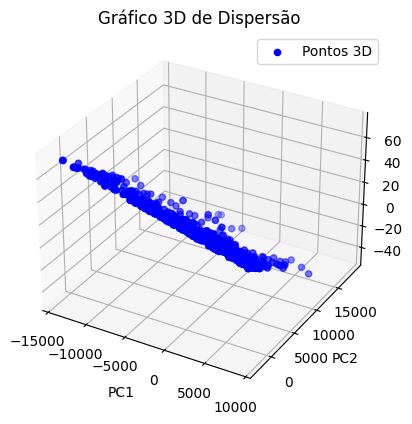

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Criação da figura e do eixo tridimensional
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersão 3D
ax.scatter(X_reduzido_test[0], X_reduzido_test[1], y_pred_reduzido, c='b', marker='o', label='Pontos 3D')

# Adicionando rótulos aos eixos
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Target')

# Adicionando um título ao gráfico
ax.set_title('Gráfico 3D de Dispersão')

# Exibindo a legenda
ax.legend()

# Exibindo o gráfico
plt.show()


# CONCLUSÃO

O modelo de regressão de Ridge adaptou-se bem ao dataset levando em conta a quantidade de exemplos presentes de diversos materiais supercondutores. Logo, pode-se dizer que o modelo é uma estratégia viável para previsão de características de materias, sendo interessante a sua aplicação para outros datasets dentro da área de propriedades de materiais.

SPOILER: Ele desempenhou bem, mas não foi o menlhor, nem de longe. Aconselho olhar os outros notebooks.

## Referências



1.  Documentação do `optuna` [https://optuna.readthedocs.io/en/stable/index.html](https://optuna.readthedocs.io/en/stable/index.html)

2.  Sobre a Ridge regression https://medium.com/@corymaklin/machine-learning-algorithms-part-11-ridge-regression-7d5861c2bc76

3. Sobre a Ridge regression https://www.mygreatlearning.com/blog/what-is-ridge-regression/#:~:text=Ridge%20regression%20is%20a%20model,away%20from%20the%20actual%20values.

4. `Documentação` do regressor linear Ridge no scikitlearn https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
